In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [85]:
raw_communities = pd.read_csv('../Data/communities.csv')
raw_egm = pd.read_csv("../Data/EGM.csv")
raw_houses = pd.read_csv("../Data/Houses-by-suburb.csv")
raw_all_offences = pd.read_excel("../Data/LGA_Offences.xlsx", sheet_name=None)
raw_offense = raw_all_offences['Table 01']

In [86]:
raw_offense = raw_all_offences['Table 01']

In [139]:
raw_egm['LGA Name'].iloc[:47]

0              CITY OF WHITTLESEA
1     SHIRE OF NORTHERN GRAMPIANS
2         CITY OF GREATER GEELONG
3            SHIRE OF COLAC-OTWAY
4              SHIRE OF MOORABOOL
5     SHIRE OF CENTRAL GOLDFIELDS
6               SHIRE OF MITCHELL
7                 SHIRE OF ALPINE
8           RURAL CITY OF BENALLA
9               SHIRE OF CAMPASPE
10               SHIRE OF GLENELG
11            Shire of Wellington
12          Rural City of Wodonga
13            City of Warrnambool
14        City of Greater Bendigo
15               City of Ballarat
16        Rural City of Swan Hill
17     City of Greater Shepparton
18          Rural City of Mildura
19        Shire of East Gippsland
20            Shire of Bass Coast
21                City of Latrobe
22            Shire of Surf Coast
23       Shire of South Gippsland
24        Shire of Macedon Ranges
25          Rural City of Horsham
26               Shire of Baw Baw
27       Rural City of Wangaratta
28              City of Melbourne
29            

In [92]:
from bs4 import BeautifulSoup
import requests

url = "https://www.vec.vic.gov.au/electoral-boundaries/local-councils"
doc = requests.get(url).text

In [167]:
soup = BeautifulSoup(doc, 'html.parser')
base = soup.find('h3', string='A')

def clean_lga(lga: str):
    lga = lga.strip().lower()
    lga = lga.replace('-', ' ')

    replaces = {
        'moreland': 'merribek'
    }
    lga = ''.join([replaces.get(word, word) for word in lga.split() if word not in ['of', 'city', 'rural', 'shire', 'borough']])

    return lga

lgas = []
for link in base.find_all_next('a'):
    text = link.text.strip()
    if text == '':
        continue
    
    lgas.append(clean_lga(' '.join(text.split(' ')[:-1]).lower()))
    if text == 'Yarriambiack Shire Council':
        break

lgas = np.unique(lgas)

@np.vectorize
def islga(name):
    for t in lgas:
        if name in t:
            return True
        
    return False

lgas[:5]

array(['alpine', 'ararat', 'ballarat', 'banyule', 'basscoast'],
      dtype='<U19')

In [168]:

# clean egm
def clean_egm(egm):
    print("CLEANING EGM")
    egm = egm.copy()
    egm = egm.iloc[:57, :]

    egm['LGA'] = egm['LGA Name'].apply(clean_lga)
    egm = egm.drop(['LGA Name'], axis=1)


    # filter only the ones in lgas
    old = pd.unique(egm['LGA'])
    egm = egm.query('@islga(LGA)')
    n = pd.unique(egm['LGA'])

    print(f"removed {np.setdiff1d(old, n)}")
    print(f"{n.size} LGAs")

    display(egm.head())

    return egm


def clean_offenses(crime):
    print('CLEANING OFFENSES')
    crime = crime.copy()
    crime = crime[crime['Local Government Area'] != 'Total']
    crime['LGA'] = crime['Local Government Area'].apply(lambda s: clean_lga(s.lower().strip()))
    crime = crime.drop(['Local Government Area'], axis=1)

    # filter only the ones in lgas
    old = pd.unique(crime['LGA'])
    crime = crime.query('@islga(LGA)')
    n = pd.unique(crime['LGA'])

    print(f"removed {np.setdiff1d(old, n)}")
    print(f"{n.size} LGAs")
    display(crime.head())
    return crime

print(f'total LGAs {len(lgas)}')
offense = clean_offenses(raw_offense)
egm = clean_egm(raw_egm)


total LGAs 79
CLEANING OFFENSES
removed ['justiceinstitutionsandimmigrationfacilities' 'unincorporatedvic']
79 LGAs


,Year,Year ending,Police Region,Offence Count,"Rate per 100,000 population",LGA
0,2023,December,1 North West Metro,8072,6256.318199,banyule
1,2023,December,1 North West Metro,17044,8666.589574,brimbank
2,2023,December,1 North West Metro,13715,8823.868581,darebin
3,2023,December,1 North West Metro,5720,6143.155350,hobsonsbay
4,2023,December,1 North West Metro,18342,7030.782116,hume


CLEANING EGM
removed []
57 LGAs


,Region,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,LGA
0,M,1.095429e+08,1.115836e+08,1.010001e+08,1.035006e+08,1.091612e+08,1.116516e+08,1.152932e+08,1.184756e+08,1.207063e+08,91066518.95,whittlesea
1,C,1.071793e+07,1.121941e+07,1.014142e+07,1.035065e+07,1.003788e+07,9.050693e+06,9.105582e+06,9.720508e+06,9.200584e+06,7004272.36,northerngrampians
2,C,1.184686e+08,1.183161e+08,1.097196e+08,1.116281e+08,1.130210e+08,1.132050e+08,1.154188e+08,1.188324e+08,1.203854e+08,89137264.73,greatergeelong
3,C,1.105642e+07,1.091608e+07,1.019461e+07,1.007489e+07,1.026330e+07,1.016289e+07,1.023095e+07,1.024279e+07,1.075162e+07,8316806.76,colacotway
4,C,1.083741e+07,1.116534e+07,1.054645e+07,1.030988e+07,1.057564e+07,1.061337e+07,1.139579e+07,1.196206e+07,1.234074e+07,9631820.68,moorabool


In [169]:
print('2024 |', ' '.join(sorted(lgas)))
print('egm |', ' '.join(sorted(egm['LGA'].unique())))
print('offense |', ' '.join(sorted(offense['LGA'].unique())))
print(np.setdiff1d(lgas, offense['LGA'].unique()))

2024 | alpine ararat ballarat banyule basscoast bawbaw bayside benalla boroondara brimbank buloke campaspe cardinia casey centralgoldfields colacotway corangamite darebin eastgippsland frankston gannawarra gleneira glenelg goldenplains greaterbendigo greaterdandenong greatergeelong greatershepparton hepburn hindmarsh hobsonsbay horsham hume indigo kingston knox latrobe loddon macedonranges manningham mansfield maribyrnong maroondah melbourne melton merribek mildura mitchell moira monash mooneevalley moorabool morningtonpeninsula mountalexander moyne murrindindi nillumbik northerngrampians portphillip pyrenees queenscliffe southerngrampians southgippsland stonnington strathbogie surfcoast swanhill towong wangaratta warrnambool wellington westwimmera whitehorse whittlesea wodonga wyndham yarra yarraranges yarriambiack
egm | alpine ballarat banyule basscoast bawbaw bayside benalla boroondara brimbank campaspe cardinia casey centralgoldfields colacotway darebin eastgippsland frankston glen

In [11]:
communities.head()

,Community Name,Region,Map reference,Grid reference,Location,Population Density,Travel time to GPO (minutes),Distance to GPO (km),LGA,Primary Care Partnership,...,Time to nearest public hospital with maternity services,Distance to nearest public hospital with maternity services,"Presentations to emergency departments, 2012-13",Nearest public hospital with emergency department,Travel time to nearest public hospital with emergency department,Distance to nearest public hospital with emergency department,Presentations to emergency departments due to injury,"Presentations to emergency departments due to injury, %",Category 4 & 5 emergency department presentations,"Category 4 & 5 emergency department presentations, %"
0,Abbotsford (Suburb),Northern and Western Metropolitan,4,C3,3km ENE of Melbourne,3082.440714,6.114670,4.264157,Yarra (C),Inner North West Primary Care Partnership,...,6.955606,5.179985,1396.274370,St Vincent's Hospital,4.571875,3.191000,323.83038328,23.192461,885.4447909200001,63.414814
1,Aberfeldie (Suburb),Northern and Western Metropolitan,4,B2,8km NW of Melbourne,2426.665450,13.410363,9.881527,Moonee Valley (C),Inner North West Primary Care Partnership,...,10.540675,7.835355,865.262419,Royal Melbourne Hospital,10.681174,7.916626,177.40004939,20.502456,487.0564898400001,56.290032
2,Aireys Inlet - Fairhaven (Catchment),Barwon-South Western,2,D4,108km SW of Melbourne,0.841522,127.057589,134.213743,Surf Coast (S),G21 Health and Wellbeing Pillar,...,79.950423,58.405921,50.832048,Geelong Hospital,79.950423,58.405921,14.44740341,28.421840,27.98233923,55.048616
3,Aireys Inlet - Fairhaven (Town),Barwon-South Western,2,D4,105km SW of Melbourne,213.059443,97.404694,124.859887,Surf Coast (S),G21 Health and Wellbeing Pillar,...,50.297529,49.052066,155.717114,Geelong Hospital,50.297529,49.052066,44.25766899,28.421840,85.72011677,55.048616
4,Airport West (Catchment),Northern and Western Metropolitan,4,B1,11km NNW of Melbourne,210.819042,13.850488,14.758418,Moonee Valley (C),Inner North West Primary Care Partnership,...,9.705913,10.312795,222.247062,Royal Melbourne Hospital,11.121299,12.793518,39.80414965,17.909865,113.66007,51.141315


In [12]:
egm.head()

,LGA Name,Region,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,CITY OF WHITTLESEA,M,1.095429e+08,1.115836e+08,1.010001e+08,1.035006e+08,1.091612e+08,1.116516e+08,1.152932e+08,1.184756e+08,1.207063e+08,91066518.95
1,SHIRE OF NORTHERN GRAMPIANS,C,1.071793e+07,1.121941e+07,1.014142e+07,1.035065e+07,1.003788e+07,9.050693e+06,9.105582e+06,9.720508e+06,9.200584e+06,7004272.36
2,CITY OF GREATER GEELONG,C,1.184686e+08,1.183161e+08,1.097196e+08,1.116281e+08,1.130210e+08,1.132050e+08,1.154188e+08,1.188324e+08,1.203854e+08,89137264.73
3,SHIRE OF COLAC-OTWAY,C,1.105642e+07,1.091608e+07,1.019461e+07,1.007489e+07,1.026330e+07,1.016289e+07,1.023095e+07,1.024279e+07,1.075162e+07,8316806.76
4,SHIRE OF MOORABOOL,C,1.083741e+07,1.116534e+07,1.054645e+07,1.030988e+07,1.057564e+07,1.061337e+07,1.139579e+07,1.196206e+07,1.234074e+07,9631820.68


In [13]:
houses.head()

,Locality,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,Change Percentage 13-23
0,ABBOTSFORD,792500,862500,925000,1187500,1280000,1192500,1050000,1200000,1365000,1346000,1250000,58.0
1,ABERFELDIE,947500,1045000,1207500,1300000,1471000,1498500,1390000,1520000,1858000,1900000,1631000,72.0
2,AINTREE,-,-,600000,600000,571000,557500,575000,616000,713500,756000,748000,NaN
3,AIREYS INLET,664000,625500,680000,715000,737500,869000,985000,1132500,1775000,1725000,1675000,152.0
4,AIRPORT WEST,532000,575000,635000,742000,845000,845000,795000,812500,960000,911000,945000,78.0


In [59]:
lga['Table 01'].head()

,Year,Year ending,Police Region,Local Government Area,Offence Count,"Rate per 100,000 population"
0,2023,December,1 North West Metro,Banyule,8072,6256.318199
1,2023,December,1 North West Metro,Brimbank,17044,8666.589574
2,2023,December,1 North West Metro,Darebin,13715,8823.868581
3,2023,December,1 North West Metro,Hobsons Bay,5720,6143.155350
4,2023,December,1 North West Metro,Hume,18342,7030.782116


<Axes: xlabel='Year'>

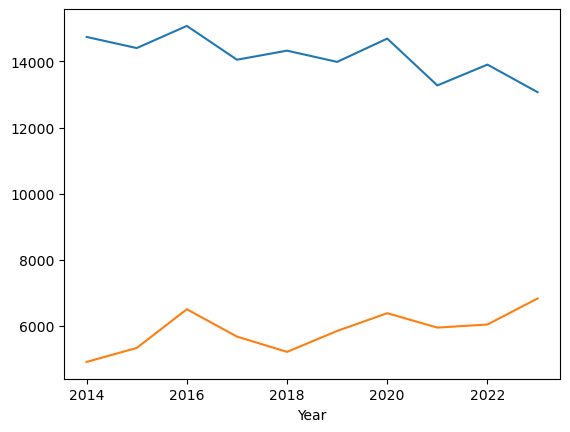

In [61]:
crime = lga['Table 01']
crime = crime[crime['Local Government Area'] != 'Total']
crime = crime.copy()
crime['LGA'] = crime['Local Government Area'].apply(lambda s: s.lower().strip())
crime.head()


yarra = crime[crime['LGA'] == 'yarra']
yarra = yarra.set_index('Year')
yarra['Rate per 100,000 population'].plot()

monash = crime[crime['LGA'] == 'monash']
monash = monash.set_index('Year')
monash['Rate per 100,000 population'].plot()

In [75]:
egm['LGA'] = egm['LGA Name'].apply(lambda s: s.lower())
egm["LGA"]

0                city of whittlesea
1       shire of northern grampians
2           city of greater geelong
3              shire of colac-otway
4                shire of moorabool
5       shire of central goldfields
6                 shire of mitchell
7                   shire of alpine
8             rural city of benalla
9                 shire of campaspe
10                 shire of glenelg
11              shire of wellington
12            rural city of wodonga
13              city of warrnambool
14          city of greater bendigo
15                 city of ballarat
16          rural city of swan hill
17       city of greater shepparton
18            rural city of mildura
19          shire of east gippsland
20              shire of bass coast
21                  city of latrobe
22              shire of surf coast
23         shire of south gippsland
24          shire of macedon ranges
25            rural city of horsham
26                 shire of baw baw
27         rural city of wan